Загрузим необходимый функционал

In [1]:
import os
import gc
import json
import joblib
import warnings
from enum import Enum

import scipy
import optuna
import implicit
import numpy as np
import pandas as pd
from src import utils
import seaborn as sns
from tqdm import notebook
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, roc_auc_score, recall_score

warnings.filterwarnings("ignore")

Определим пути до файлов

In [2]:
class Paths(Enum):
    account_cols = "auxiliary/account_cols.txt"
    credit_cols = "auxiliary/credit_cols.txt"
    income_cols = "auxiliary/income_cols.txt"
    info_cols = "auxiliary/info_cols.txt"
    transactions_cols = "auxiliary/transactions_cols.txt"
    train_last = "data/train_last_v3.csv"

Загрузим данные тренировочного набора, в которых уже имеется таргет, логика сбора которого описана в EDA

In [3]:
train = pd.read_csv(Paths.train_last.value)

Проверим, а не ли часом пропусков по таргету

In [4]:
train["target"].isna().sum()

3132

Пропуски есть; удалим их и реиндексируем датасет

In [5]:
train.drop(
    train.loc[train["target"].isna()].index,
    axis=0,
    inplace=True
)
train.reset_index(drop=True, inplace=True)

gc.collect();

train.shape

(288747, 295)

Выполним приведение типов, чтобы сократить потребеление памяти

In [6]:
train = utils.reduce_mem_usage(train)

[было]: 649.875 Мб
[стало]: 260.978 Мб
[оптимизировано]: 59.842 %


В данных содержится отчётная дата сбора данных и дата выдачи карты, чтобы не "таскать" с собой эти признаки, удалим их, т.к. в контексте данного набора данных они не нужен. В общем и целом, дату можно было распарсить и вытащить оттуда следующие фичи:
 - день недели;
 - номер месяца;
 - номер недели;
 - год;
 - определить, является ли день недели выходным;
 - определить, является ли дата праздничным днём
 
Также удалим и айди клиента, т.к. этот признак не будет участвовать в обучении модели
 
Дополнительно удаляем признак "clientoutflowstatus", т.к. эта фича является в нашем решении вторым таргетом - для моделирования оттока клиентов

In [7]:
train.drop(
    ["dt", "cardapp_date", "client_id", "clientoutflowstatus"],
    axis=1,
    inplace=True
)
gc.collect();

Для работы с сырыми данными необходимо обработать номинативные переменные.  
В качестве исходного кодирования возьмём onehot encoding. Ранги ставить будет неправильно, т.к. на множестве номинативных переменных не заданы операции сравнения  
Определим для начала все такие фичи

In [8]:
cat_features = [
    col
    for col in list(train)
    if not str(train[col].dtype).startswith("float")
]
print(len(cat_features))
print(*cat_features)

7
country stratsegfactor srvpackage clientsegment gender addrref hdb_relend_client_credits_count_grade


Проверим, имеются ли пропуски в данных по эти признакам

In [9]:
train[cat_features].isna().sum()

country                                       0
stratsegfactor                            87210
srvpackage                                70120
clientsegment                             76358
gender                                    70076
addrref                                   78567
hdb_relend_client_credits_count_grade    174566
dtype: int64

Пропусков очень много.  
Исходной стратегией работы с пропусками для номинативных переменных будет заполнение пропусков модой по столбцу, а для количественных переменных - заполнение нулями

In [10]:
for col in cat_features:
    train[col].fillna(train[col].mode()[0], inplace=True)
    
train[cat_features].isna().sum().sum()

0

Теперь перейдём к onehot, но отдельно сохраним признак - "пакет услуг клиента"; он нам позже понадобится

In [11]:
srvpackage_vals = train["srvpackage"]
train = pd.get_dummies(data=train, columns=cat_features, drop_first=True, dtype=np.uint8)
train.shape

(288747, 355)

Выделим количественные признаки и заполним пропуски

In [12]:
quant_features = [
    col
    for col in list(train)
    if str(train[col].dtype).startswith("float")
]
quant_features.remove("target")
len(quant_features)

283

In [13]:
for col in notebook.tqdm(quant_features):
    train[col].fillna(0.0, inplace=True)

  0%|          | 0/283 [00:00<?, ?it/s]

Сделаем чекап пропусков в данных

In [14]:
train[quant_features].isna().sum().sum()

0

Отлично; теперь пропусков в данных нет.  
Проверим, какие типы данных присутствуют в датасете

In [15]:
train.dtypes.value_counts()

float32    164
float16    120
uint8       71
dtype: int64

Прекрасно. Категориальных переменных в датасете не осталось

Датасет несбалансированный, поэтому необходимы подходы для работы:
1) использовать алгоритмы upsampling данных, например, SMOTE;
2) использовать алгоритмы downsampling данных: из исходных данных тянуть выборки с одинаковым соотношением целевых меток

Используем второй подход в качестве исходного и сэмплируем 10 выборок с негативным классом, объёмом равным объёму датасета с положительным классом

In [16]:
np.random.seed(11)

amout_of_pos = train["target"].value_counts().loc[1]

dfs = [
    pd.concat([
        train[train["target"] == 0].sample(amout_of_pos),
        train[train["target"] == 1]
    ]).reset_index(drop=True)
    for _ in notebook.tqdm(range(10))
]

del amout_of_pos
gc.collect();

print(f"объём одного датасета равен {dfs[0].shape[0]}")

  0%|          | 0/10 [00:00<?, ?it/s]

объём одного датасета равен 97434


Перейдём к выбору модели. В качестве рассматриваемых моделей возьмём алгоритмы линейного, "деревянного" и бустинговых семейств:
 - логистическая регрессия;
 - дерево решений;
 - случайный лес;
 - градиентный бустинг реализаций от Яндекса, Microsoft и XGBoost.

Для LGBMClassifier добавим параметр force_col_wise, чтобы ускорить процесс обучения модели за счёт уменьшения кол-ва используемой памяти.

На начале все алгоритмы будут представлены с дефолтными параметрами.  
Перформанс модели будем оценивать по совокупности метрик:
- f1;
- roc-auc;
- recall;
- precision

Для валидации будем использовать 10 фолдовую валидацию со стратификацией

Определим модели и настроим валидацию

In [17]:
clfs = [
    ("lr", LogisticRegression(random_state=11, n_jobs=-1)),
    ("dt", DecisionTreeClassifier(random_state=11)),
    ("rf", RandomForestClassifier(random_state=11)),
    ("cb", CatBoostClassifier(random_seed=11, verbose=0, task_type="GPU")),
    ("xgb", XGBClassifier(random_state=11)),
    ("lgbm", LGBMClassifier(random_state=11, force_col_wise=True, verbose=-1))
]

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

Селект модели будем производить по ф-мере, т.к. если учитывать всю совокупность метрик, то получим довольно-таки тяжёлое по времени решение ($O(m*c*n^2)$ - цикл, который проходится по совокупность метрик (m = 4), цикл, который проходится по классификаторам (c = 6), цикл, который проходится по сэмплированным датасетам (n = 10), и цикл, который проходится по фолдам (n = 10))

Перейдём к обучению классификаторов

In [18]:
np.random.seed(11)

cols = list(train)
cols.remove("target")

res = dict()
for val in notebook.tqdm(clfs):
    clf = val[1]
    scores = []
    
    for df in notebook.tqdm(dfs):
        y, x = df["target"], df[cols]
        tmp_scores = []
        
        for train_idx, val_idx in kfold.split(x, y):
            x_train, x_val = x.loc[train_idx], x.loc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            clf.fit(x_train, y_train)
            tmp_scores.append(
                round(f1_score(y_val, clf.predict(x_val), average="binary"), 7)
            )
            
        scores += [
            min(tmp_scores),
            max(tmp_scores),
            np.mean(tmp_scores)
        ]
        
    res[val[0]] = scores
    joblib.dump(clf, f"models/{val[0]}_downsampled.pkl")

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Т.к. на обучение всех моделей потребовалось немало времени, то сохраним результаты (значения метрик и время обучения) и визуализируем их (разумеется, кроме времени)

In [19]:
with open("res_json.json", 'w') as file:
    json.dump(res, file)
    
time_res = {
    "lr": 12 * 60 + 19,
    "dt": 33 * 60 + 11,
    "rf": 96 * 60 + 2,
    "cb": 26 * 60 + 46,
    "xgb": 50 * 60 + 30,
    "lgbm": 6 * 60 + 44,
}

with open("time_res_json.json", 'w') as file:
    json.dump(time_res, file)

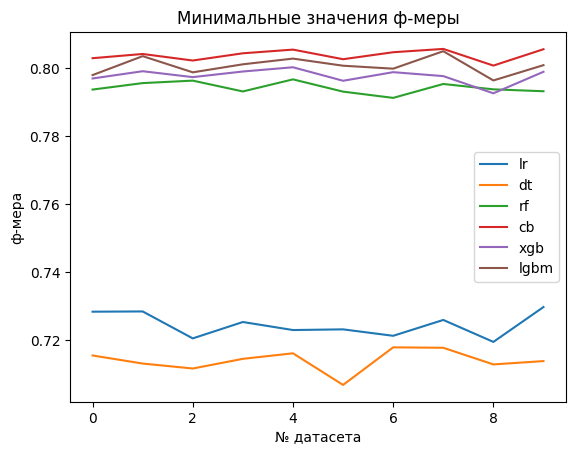

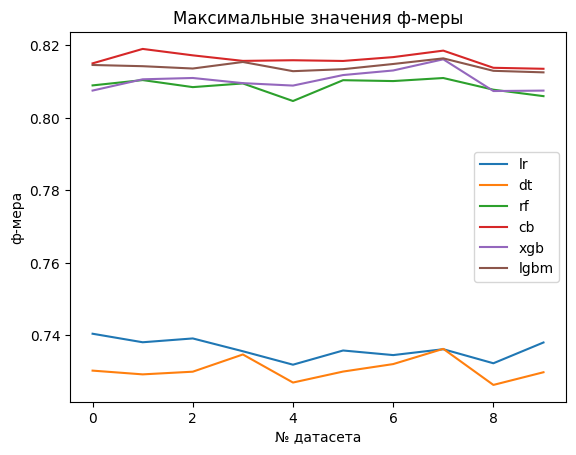

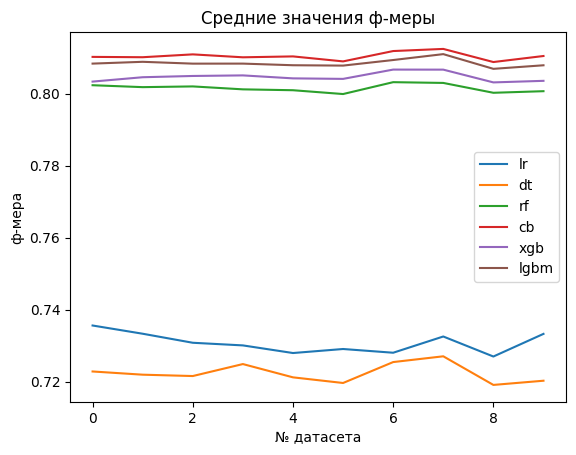

In [20]:
utils.plot_values(0, res)
utils.plot_values(1, res)
utils.plot_values(2, res)

Получается, что логистическая регрессия, дерево решений, случайный лес, а также градиентный бустинг реализации XGBoost показали плохие результаты по значениям ф-меры. На градиентные бустинги от Яндекса и Microsoft глянем поближе

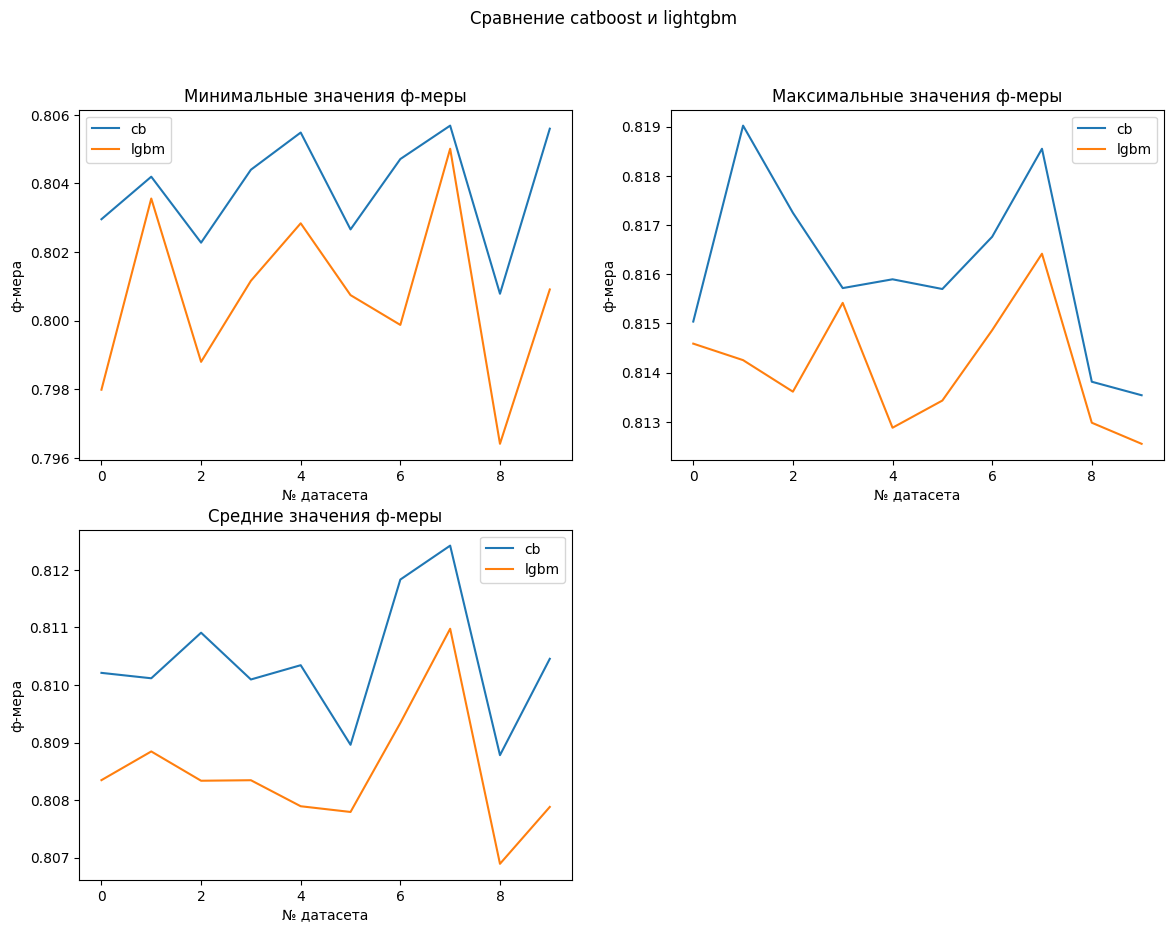

In [21]:
utils.compare_plot("cb", "lgbm", res)

Значения ф-меры для catboost не намного выше, чем для lightgbm. Глянем, какой порядок создаёт разницу. Для этого посчитаем разницу между всеми (минимальными, максимальными и средними) скорами моделей и возьмём среднее значение

In [22]:
print(f"[разница для минимума] {round((np.asarray(res['cb'][::3]) - np.asarray(res['lgbm'][::3])).mean(), 7)}")
print(f"[разница для максимума] {round((np.asarray(res['cb'][1::3]) - np.asarray(res['lgbm'][1::3])).mean(), 7)}")
print(f"[разница для среднего] {round((np.asarray(res['cb'][2::3]) - np.asarray(res['lgbm'][2::3])).mean(), 7)}")

[разница для минимума] 0.0031446
[разница для максимума] 0.0020286
[разница для среднего] 0.0019484


Разницу в скорах задаём тысячный порядок ф-меры. 

А какая разница в скоростях обучения для этих моделей?

In [26]:
print(round(time_res["cb"] / time_res["lgbm"], 1))

del time_res
gc.collect();

4.0


Таким образом, основываясь на представленных выше результатах, мы выбираем <strong>LGBMClassifier</strong>, потому что:
1) CatBoostClassifier и LGBMClassifier показывают одинаковые скоры в точности до второго знака после запятой; разница начинает появляться лишь в третьем знаке после запятой;
2) скорость обучения LGBMClassifier в 4 быстрее, чем CatBoostClassifier (хотя данный классификатор обучался на ГПУ)

Результаты средних оценок обучения моделей сохраним в отдельный файл (вдруг нам эти результаты понадобятся ещё)

In [27]:
min_, max_, mean_ = [], [], []
for key in res.keys():
    min_.append(np.mean(res[key][::3]))
    max_.append(np.mean(res[key][1::3]))
    mean_.append(np.mean(res[key][2::3]))

pd.DataFrame(columns=res.keys(), index=["min", "mean", "mean"], data=[min_, mean_, max_]).to_csv("select_model.csv")

del min_, max_, mean_
gc.collect();

Выбор модели проводили, используя downsampling мажорного (доминатного) класса. Теперь посмотрим, как будет вести себя дефолтный классификатор - LGBMClassifier - если сэмплируем минорный класс. Для сэмплирования будем использовать:
1) алгоритм SMOTE модуля imblearn, который под капотом имплементирует метод ближайших соседей, для генерирования синтетических сэмплов;
2) собственноручно написанный алгоритм upsample, который реализует стратегию дублирования сэмплов минорного класса

Для начала узнаем перформанс модели на дефолтном соотношении таргета

In [28]:
default_res = utils.validate(
    train[cols],
    train["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)
print(f"[среднее значение]: {round(np.mean(default_res), 7)}")

del default_res
gc.collect();

0it [00:00, ?it/s]

[среднее значение]: 0.5698729


Дисбаланс очень сильно сказывается. Значит, или downsampling, или upsampling будем использовать, чтобы нивелировать импакт дисбаланса на перформанс модели

Теперь перейдём к тестированию подходов upsampling. Используем реализацию upsampling модуля imblearn

In [29]:
np.random.seed(11)
    
smote = SMOTE(sampling_strategy="minority", k_neighbors=10,  random_state=11)
train_res, target_res = smote.fit_resample(train[cols], train["target"])

train_res["target"] = target_res

del target_res
gc.collect();

train_res["target"].value_counts()

1.0    240030
0.0    240030
Name: target, dtype: int64

Провалидируем наш дефолтный классификатор

In [30]:
smote_res = utils.validate(
    train_res[cols],
    train_res["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)
print(f"[среднее значение]: {round(np.mean(smote_res), 7)}")

del smote_res
gc.collect();

0it [00:00, ?it/s]

[среднее значение]: 0.8960519


Итак, LGBMClassifier + SMOTE дали прирост в ф-мере на 9%, что довольно-таки сильно (исходный скор: 0.8084649)

Используем наш алгоритм upsampling и посмотрим, изменится ли картина с переобучением

In [32]:
x_train_upsampled, y_train_upsampled = utils.upsample(
    train[cols],
    train["target"],
    train[train["target"] == 0].shape[0] // train[train["target"] == 1].shape[0]
)

x_train_upsampled["target"] = y_train_upsampled
x_train_upsampled.reset_index(drop=True, inplace=True)

del y_train_upsampled
gc.collect();

In [33]:
upsample_res = utils.validate(
    x_train_upsampled[cols],
    x_train_upsampled["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)
print(f"[среднее значение]: {round(np.mean(upsample_res), 7)}")

del x_train_upsampled, upsample_res
gc.collect();

0it [00:00, ?it/s]

[среднее значение]: 0.7950085


Функция upsample показала результаты хуже, чем SMOTE, но это и понятно, почему. Дублирование сэмплов минорного класса - это далеко не лучшая стратегия upsampling

Необходимо также учитывать, что дефолтный классификатор мог переобучиться. Всё дело в том, что дефолтный классификатор не имеет:
1) ограничений по глубине деревьев;
2) максимальное значение листьев для каждого дерева равно 31;
3) коэффициенты регуляризации ($l_1$, $l_2$) занулены.

Однако, для дальнейшей работы возьмём комбинацию LGBMClassifier + SMOTE.  
Выбор модели, валидация LGBMClassifier производились можно сказать, что на сырых данных. Однако, мы имеем профили пользователей.  
<strong>Гипотеза 1: обучение на профилях пользователя позволит получить лучший скор</strong>  
<strong>Гипотеза 2: обучение на эмбеддингах профилей позволит получить лучший скор</strong>
Давайте это проверим

Итеративно будем тестировать профили и начнём с самого большого - транзакционного.  
Последовательность будет такой: для начала обучим классификатор + smote на сырых данных, а затем аналогичную операцию проведём с эмбеддингами

In [34]:
transactions_cols = utils.load_profile(Paths.transactions_cols.value)

_ = utils.check_profile_without_smote(
    transactions_cols,
    train
)

профиль содержит [199] признака(-ов)


0it [00:00, ?it/s]

[среднее значение]: 0.4995297


In [35]:
_ = utils.check_profile(
    transactions_cols,
    train
)

0it [00:00, ?it/s]

[среднее значение]: 0.8565582


Транзакционный профиль показал значение ф-меры меньше относительно сырых данных

Для получения эмбеддингов будем использовать матричную факторизацию - ALS (подход взят из области рекомендательных систем).  
Кол-во факторов будем брать меньше, чем кол-во исходных признаков в профиле. Если кол-во факторов будет больше, то мы спокойно переобучимся

In [36]:
transactions_embeds = utils.get_embdes(
    train[transactions_cols],
    train["target"],
    128
)

transactions_profile_embeds_res = utils.validate(
    transactions_embeds.iloc[:, :128],
    transactions_embeds["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)
print(f"[среднее значение]: {round(np.mean(transactions_profile_embeds_res), 7)}")

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[среднее значение]: 0.4818215


Провалидируем классификатор + smote для эмбеддингов

In [37]:
_ = utils.check_profile(
    list(transactions_embeds)[:128],
    transactions_embeds
)

del transactions_cols, transactions_embeds, transactions_profile_embeds_res
gc.collect();

0it [00:00, ?it/s]

[среднее значение]: 0.7724128


Вывод сделаем после того, как проверим все профили, а пока перейдём к счётному профилю:
1) чекап на сырых признаках профиля;
2) чекап на сырых + smote;
3) чекап на эмбеддингах профиля;
4) чекап на эмбеддингах профиля + smote

Такой алгоритм верен для всех профилей пользователя

In [38]:
account_cols = utils.load_profile(Paths.account_cols.value)

_ = utils.check_profile_without_smote(
    account_cols,
    train
)

профиль содержит [30] признака(-ов)


0it [00:00, ?it/s]

[среднее значение]: 0.4602122


In [39]:
_ = utils.check_profile(
    account_cols,
    train
)

0it [00:00, ?it/s]

[среднее значение]: 0.8136339


In [40]:
account_embeds = utils.get_embdes(
    train[account_cols],
    train["target"],
    16
)

account_profile_embeds_res = utils.validate(
    account_embeds.iloc[:, :16],
    account_embeds["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)
print(f"[среднее значение]: {round(np.mean(account_profile_embeds_res), 7)}")

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[среднее значение]: 0.3359583


In [41]:
_ = utils.check_profile(
    list(account_embeds)[:16],
    account_embeds
)

del account_cols, account_embeds, account_profile_embeds_res
gc.collect();

0it [00:00, ?it/s]

[среднее значение]: 0.7758593


Теперь посмотрим на импакт кредитного профиля. Предварительно заменив категориальную фичу в профиле на её onehot вектора

In [42]:
credit_cols = utils.load_profile(Paths.credit_cols.value)

credit_cols.remove("hdb_relend_client_credits_count_grade")
credit_cols += list(filter(
    lambda x: x.startswith("hdb_relend_client_credits_count_grade"),
    list(train)
))
print(len(credit_cols))

профиль содержит [44] признака(-ов)
46


In [43]:
_ = utils.check_profile_without_smote(
    credit_cols,
    train
)

0it [00:00, ?it/s]

[среднее значение]: 0.3466724


In [44]:
_ = utils.check_profile(
    credit_cols,
    train
)

0it [00:00, ?it/s]

[среднее значение]: 0.8382856


In [45]:
credit_embeds = utils.get_embdes(
    train[credit_cols],
    train["target"],
    32
)

credit_profile_embeds_res = utils.validate(
    credit_embeds.iloc[:, :32],
    credit_embeds["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)
print(f"[среднее значение]: {round(np.mean(credit_profile_embeds_res), 7)}")

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[среднее значение]: 0.1384465


In [46]:
_ = utils.check_profile(
    list(credit_embeds)[:32],
    credit_embeds
)

del credit_cols, credit_embeds, credit_profile_embeds_res
gc.collect();

0it [00:00, ?it/s]

[среднее значение]: 0.7092487


Рассмотрим доходный профиль

In [47]:
income_cols = utils.load_profile(Paths.income_cols.value)

_ = utils.check_profile_without_smote(
    income_cols,
    train
)

профиль содержит [8] признака(-ов)


0it [00:00, ?it/s]

[среднее значение]: 0.4252299


In [48]:
_ = utils.check_profile(
    income_cols,
    train
)

0it [00:00, ?it/s]

[среднее значение]: 0.7353472


In [49]:
income_embeds = utils.get_embdes(
    train[income_cols],
    train["target"],
    4
)

income_profile_embeds_res = utils.validate(
    income_embeds.iloc[:, :4],
    income_embeds["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)
print(f"[среднее значение]: {round(np.mean(income_profile_embeds_res), 7)}")

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[среднее значение]: 0.3699728


In [50]:
_ = utils.check_profile(
    list(income_embeds)[:4],
    income_embeds
)

del income_cols, income_embeds, income_profile_embeds_res
gc.collect();

0it [00:00, ?it/s]

[среднее значение]: 0.7185149


Теперь посмотрим на последний профиль информационный, предварительно заменив исходные номинативные переменные профиля на их onehot представления

In [53]:
info_cols = utils.load_profile(Paths.info_cols.value)
info_cols.remove("clientoutflowstatus")

add_to_income_cols = []
for col in [
    "country", "stratsegfactor", "srvpackage",
    "clientsegment", "gender"
]:
    add_to_income_cols += list(filter(
        lambda x: x.startswith(col),
        list(train)
    ))
    info_cols.remove(col)

info_cols += add_to_income_cols
print(len(info_cols))

del add_to_income_cols
gc.collect();

профиль содержит [9] признака(-ов)
26


In [54]:
_ = utils.check_profile_without_smote(
    info_cols,
    train
)

0it [00:00, ?it/s]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[среднее значение]: 0.4690335


In [55]:
_ = utils.check_profile(
    info_cols,
    train
)

0it [00:00, ?it/s]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[среднее значение]: 0.8726796


In [57]:
info_embeds = utils.get_embdes(
    train[info_cols],
    train["target"],
    16
)

info_profile_embeds_res = utils.validate(
    info_embeds.iloc[:, :16],
    info_embeds["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)
print(f"[среднее значение]: {round(np.mean(info_profile_embeds_res), 7)}")

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[среднее значение]: 0.4619603


In [59]:
_ = utils.check_profile(
    list(info_embeds)[:16],
    info_embeds
)

del info_cols, info_embeds, info_profile_embeds_res
gc.collect();

0it [00:00, ?it/s]

[среднее значение]: 0.7620142


В завершении тестировании этих гипотез оценим перформанс модели на эмбеддингах всех данных

In [61]:
all_embeds = utils.get_embdes(
    train[cols],
    train["target"],
    256
)

all_profile_embeds_res = utils.validate(
    all_embeds.iloc[:, :256],
    all_embeds["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)
print(f"[среднее значение]: {round(np.mean(all_profile_embeds_res), 7)}")

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[среднее значение]: 0.441572


In [62]:
_ = utils.check_profile(
    list(all_embeds)[:256],
    all_embeds
)

del all_embeds, all_profile_embeds_res
gc.collect();

0it [00:00, ?it/s]

[среднее значение]: 0.798497


Перейдём к выводу. Для начала посмотрим на результаты применения подходов для работы с несбалансированным датасетом:
1) использовали downsampling (сэмплировали 10 выборок, в которых одинаковое соотношение классов);
2) smote реализации imblearn;
3) собственноручно написанная функция upsample, которая использует стратегию дублирования сэмплов

В итоге получили вот такие результаты

<table>
    <tr>
        <td></td>
        <td>downsampling</td>
        <td>SMOTE</td>
        <td>upsample</td>
        <td>default</td>
    </tr>
        <td>lgbm</td>
        <td>0.8084648</td>
        <td>0.8960519</td>
        <td>0.7950085</td>
        <td>0.5698729</td>
    </tr>
</table>

Как видно из этой таблицы лучшим подходом оказался <strong>SMOTE</strong>. Причём он значительно выигрывает у "сырых" данных и даёт прирост на 10% ф-меры относительно стратегии downsampling

Теперь что касается подходом. Результаты по всем подходам представлены в таблице ниже.
<table>
    <tr>
        <td>подход/профиль</td>
        <td>транзакционный</td>
        <td>счётный</td>
        <td>кредитный</td>
        <td>доходный</td>
        <td>информационный</td>
        <td>все данные</td>
    </tr>
    <tr>
        <td>lgbm</td>
        <td>0.4995297</td>
        <td>0.4602122</td>
        <td>0.3466724</td>
        <td>0.4252299</td>
        <td>0.4690335</td>
        <td>0.5698729</td>
    </tr>
    <tr>
        <td>lgbm + smote</td>
        <td>0.8565582</td>
        <td>0.8136339</td>
        <td>0.8382856</td>
        <td>0.7353472</td>
        <td>0.8726796</td>
        <td>0.8960519</td>
    </tr>
    <tr>
        <td>lgbm embeds</td>
        <td>0.4818215</td>
        <td>0.3359583</td>
        <td>0.1384465</td>
        <td>0.3699728</td>
        <td>0.4619603</td>
        <td>0.4415720</td>
    </tr>
    <tr>
        <td>lgbm embeds + smote</td>
        <td>0.7724128</td>
        <td>0.7758593</td>
        <td>0.7092487</td>
        <td>0.7185149</td>
        <td>0.7620142</td>
        <td>0.7984970</td>
    </tr>
</table>

Как видно из таблицы на всех данных, а также на всех профилях пользователей самым лучшим подходом оказался <strong>lgbm + smote</strong>, а самым плохим - lgbm embeds, т.е. классификатор, который обучался на эмбеддингах, полученных при помощи матричной факторизации.

Значит, из всех подходов мы оставляем классификатора от Microsoft, который будет обучаться на данных, в которых посредством метода ближайших ссоседей сэмплируется минорный класс, чтобы нивелироваться ассиметрию в распределении меток целевого класса

В данных присутствует такая фича как "Пакет услуг клиента на отчетную дату", посмотрим на уникальные значения этой переменной

In [63]:
srvpackage_vals.unique().tolist()

['Технический',
 'Премиум',
 'Эконом',
 'Максимум+',
 'Комфорт',
 'Корпоративный',
 'длякредитовидепозитов',
 'Оптимум',
 'Класс',
 'Другое ',
 'МаксимумUltrafree',
 'ОптимумUltra',
 'А-Клуб',
 'ЭкономUltra']

С сайта альфа-банка мы спарсили описание этих услуг и с помощью <strong>ruBert</strong> построили их эмбеддинги

In [64]:
srvpackage_embeds = pd.read_csv("data/embed_package.csv")

Удалим onehot вектора по признаку "srvpackage" и восстановим её исходное номинативное представление

In [65]:
cols_to_drop = list(filter(
    lambda x: x.startswith("srvpackage"),
    list(train)
))

train.drop(cols_to_drop, axis=1, inplace=True)
train["srvpackage"] = srvpackage_vals

del cols_to_drop, srvpackage_vals
gc.collect();

Теперь присоединим эмбеддинги фичи "srvpackage" и удалим её номинативное представление

In [66]:
train_new = train.merge(srvpackage_embeds, on="srvpackage", how="left")
train_new.drop("srvpackage", axis=1, inplace=True)

del srvpackage_embeds
gc.collect();

Проверим, имеются ли пропуски в данных

In [67]:
train_new.isna().sum().sum()

149769984

Заполним эти пропуски, которые образовались на месте новых эмбеддингах, нулями

In [68]:
train_new.fillna(0.0, inplace=True)

Отлично, пропусков теперь нет. Провалидируем модель на новых данных

In [69]:
new_cols = list(train_new) 
new_cols.remove("target")

new_embeds_score = utils.validate(
    train_new[new_cols],
    train_new["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)
print(f"[среднее значение]: {round(np.mean(new_embeds_score), 7)}")

del new_embeds_score
gc.collect();

0it [00:00, ?it/s]

[среднее значение]: 0.5694315


Получили ф-меру, близкую к значению скора на "сырых" данных

Добавим сюда SMOTE и посмотрим, что получим

In [70]:
_ = utils.check_profile(
    new_cols,
    train_new
)

del train_new, new_cols
gc.collect()

0it [00:00, ?it/s]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[среднее значение]: 0.8960119


55

Получается так, что эмбеддинги не вносят абсолютно никакого вклада, т.к. скор получился равным как на "сырых" данных

Прогнав много разных подходов, фиксируем следующее:
 - будем использовать <strong>LGBMClassifier + SMOTE</strong>, т.к. этот подход показывает самые лучшие результаты относительно остальных;
 - будем использовать "сырые" данные, т.к. ни эмбеддинги, полученные с помощью матричной факторизации, ни добавление новых эмбеддингов признака "пакет услуг клиента" не то, что не добавляют в ф-мере, они, хуже того, уменьшают её значение
 
Ранее зафиксировали совокупность метрик, на основании которой будем проводить комплексную оценку перформанса модели. Поэтому используя выбранный нами подход и совокупность метрик, посмотрим на прирост по каждому показателю, сравнивая между собой следующие два пайплайна:
1) LGBMClassifier + downsampling (это наш базовый подход, на основании которого производили селект модели);
2) LGBMClassifier + SMOTE  (это выбранный нами подход, который показывает лучше всего себя относительно других подходов)

Оценим сперва наш базовый подход - LGBMClassifier + downsampling

In [71]:
down_metrics = utils.downsampling_validate(
    dfs,
    cols,
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)

  0%|          | 0/10 [00:00<?, ?it/s]

Теперь оценим выбранный нами подход - LGBMClassifier + SMOTE, а затем сравним результаты

In [75]:
train = pd.get_dummies(data=train, columns=["srvpackage"], drop_first=True)
up_metrics = utils.smote_validate(
    train[cols],
    train["target"],
    params={"random_state": 11, "verbose": -1, "force_col_wise": True}
)

0it [00:00, ?it/s]

Посмотрим на совокупности метрик при различный подходах

In [76]:
print(*down_metrics)
print(*up_metrics)

0.8084649 0.8086224 0.8091212 0.8078372
0.8960519 0.9012957 0.9463223 0.8508561


Итак, таблица сравнения этих двух подходов выглядит так:

<table>
    <tr>
        <td></td>
        <td>lgbm + downsampling</td>
        <td>lgbm + upsampling</td>
        <td>diff</td>
    </tr>  
    <tr>
        <td>f1</td>
        <td>0.8084649</td>
        <td>0.8960519</td>
        <td>+8.8%</td>
    </tr> 
    <tr>
        <td>roc-auc</td>
        <td>0.8086224</td>
        <td>0.9012957</td>
        <td>+9.3%</td>
    </tr>  
    <tr>
        <td>precision</td>
        <td>0.8091212</td>
        <td>0.9463223</td>
        <td>+13.7%</td>
    </tr>  
    <tr>
        <td>recall</td>
        <td>0.8078372</td>
        <td>0.8508561</td>
        <td>+4.3%</td>
    </tr>   
</table>

Из таблицы видно, что выбранный нами подход даёт прирост по каждой метрике. Минимум +4%, а для precision - аж почти +14%.  
Осталось подобрать гиперпараметры модели, ведь до текущего момента мы всё ещё использовали дефолтный классификатор. Подбор параметров будем делать с помощью модуля optuna, а в качестве гиперпараметров модели выберем следующее:
 - num_leaves - кол-во листьев в каждом дереве;
 - max_depth - максимальная глубина дерева;
 - n_estimators - кол-во дерерьев;
 - learning_rate - скорость обучения;
 - reg_alpha - коэффициент для $l_1$ регуляризации;
 - reg_lambda - коэффициент для $l_2$ регуляризации;
 - min_data_in_leaf - кол-во точек, попавших в лист
 
Параметры n_estimators и learning_rate подбираем, чтобы получить скор выше, а совокупность параметров num_leaves, max_depth, reg_alpha, reg_lambda и min_data_in_leaf нужна для того, чтобы сформировать ограничения на веса модели и получить более состоятельные весовые коэффициенты.

Т.к. наш классификатор учится довольно быстро, установим кол-во прогонов подбора параметров в 50.
Подбор параметров будем осуществлять, используя стратифицированную холдаут стратегию на ресэмплированных данных SMOTE

Проведём сперва upsampling данных

In [78]:
np.random.seed(11)

smote = SMOTE(
    sampling_strategy="minority",
    k_neighbors=10,
    random_state=11
)

train_res, y_res = smote.fit_resample(train[cols], train["target"])

Разобьём на наши данные на две части, используя стратифицированную холдаут стратегию

In [79]:
np.random.seed(11)

x_train, x_val, y_train, y_val = train_test_split(
    train_res,
    y_res,
    test_size=0.2,
    shuffle=True,
    stratify=y_res,
    random_state=11
)

Напишем целевую функцию для подбора параметров

In [80]:
def objective(trial):

    params = {
        "num_leaves ": trial.suggest_int("num_leaves", 5, 50),
        "max_depth ": trial.suggest_int("max_depth", 2, 30),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, log=True),
        "learning_rate": trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.001, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50)
    }

    clf = LGBMClassifier(**params, random_state=11, verbose=-1, force_col_wise=True)
    clf.fit(x_train, y_train)

    return round(f1_score(y_val, clf.predict(x_val), average="binary"), 7)

Проведём подбор гиперпараметров нашего классификатора

In [81]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=1800, n_jobs=-1, show_progress_bar=True)

[I 2023-04-02 21:53:13,406] A new study created in memory with name: no-name-7c6eff17-d8c5-4cc7-9be8-6525f6a5988f


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-04-02 21:56:30,191] Trial 6 finished with value: 0.8508735 and parameters: {'num_leaves': 39, 'max_depth': 21, 'n_estimators': 101, 'learning_rate': 0.0034979161742324594, 'reg_alpha': 0.0052057752724387505, 'reg_lambda': 0.9206831997105676, 'min_data_in_leaf': 47}. Best is trial 6 with value: 0.8508735.
[I 2023-04-02 21:56:32,996] Trial 11 finished with value: 0.846734 and parameters: {'num_leaves': 21, 'max_depth': 3, 'n_estimators': 101, 'learning_rate': 0.0025425694662649483, 'reg_alpha': 0.10237569837602563, 'reg_lambda': 0.8959750069665092, 'min_data_in_leaf': 45}. Best is trial 6 with value: 0.8508735.
[I 2023-04-02 21:56:46,641] Trial 0 finished with value: 0.8982377 and parameters: {'num_leaves': 46, 'max_depth': 18, 'n_estimators': 125, 'learning_rate': 0.32739369249774336, 'reg_alpha': 0.17255780263226744, 'reg_lambda': 0.9258873055388199, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.8982377.
[I 2023-04-02 21:57:17,988] Trial 9 finished with value: 0.899016

[I 2023-04-02 22:20:38,377] Trial 25 finished with value: 0.9002668 and parameters: {'num_leaves': 50, 'max_depth': 8, 'n_estimators': 859, 'learning_rate': 0.03990265819392292, 'reg_alpha': 0.3603775539563236, 'reg_lambda': 0.3115686139073775, 'min_data_in_leaf': 36}. Best is trial 3 with value: 0.9006771.
[I 2023-04-02 22:22:37,831] Trial 27 finished with value: 0.9004148 and parameters: {'num_leaves': 50, 'max_depth': 9, 'n_estimators': 846, 'learning_rate': 0.0492762360453839, 'reg_alpha': 0.3161822002096809, 'reg_lambda': 0.2893565224424318, 'min_data_in_leaf': 37}. Best is trial 3 with value: 0.9006771.
[I 2023-04-02 22:23:45,862] Trial 26 finished with value: 0.9008774 and parameters: {'num_leaves': 34, 'max_depth': 7, 'n_estimators': 930, 'learning_rate': 0.04254121076855816, 'reg_alpha': 0.30442303662138076, 'reg_lambda': 0.26580810429710855, 'min_data_in_leaf': 36}. Best is trial 26 with value: 0.9008774.
[I 2023-04-02 22:25:38,741] Trial 30 finished with value: 0.900586 and 

Посмотрим, какой скор удалось получить, и какие при этом параметры

In [82]:
study.best_value

0.9014976

In [83]:
best_params = study.best_params
best_params["random_state"] = 11
best_params["verbose"] = -1
best_params["force_col_wise"] = True

study.best_params

{'num_leaves': 43,
 'max_depth': 6,
 'n_estimators': 939,
 'learning_rate': 0.1325993494491041,
 'reg_alpha': 0.28560942825211894,
 'reg_lambda': 0.3218016758032404,
 'min_data_in_leaf': 36}

Провалидируем наш классификатор на лучшем сете параметров

In [84]:
best_metrics = utils.smote_validate(
    train[cols],
    train["target"],
    params=best_params
)
best_metrics

0it [00:00, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min

(0.900548, 0.9055243, 0.9506214, 0.8554889)

Сведём все данные в таблицу и получим:
<table>
    <tr>
        <td></td>
        <td>lgbm + downsampling</td>
        <td>lgbm + upsampling</td>
        <td>optuna(lgbm + upsampling)</td>
        <td>diff</td>
    </tr>  
    <tr>
        <td>f1</td>
        <td>0.8084649</td>
        <td>0.8960519</td>
        <td>0.900548</td>
        <td>+0.45%</td>
    </tr> 
    <tr>
        <td>roc-auc</td>
        <td>0.8086224</td>
        <td>0.9012957</td>
        <td>0.9055243</td>
        <td>+0.43%</td>
    </tr>  
    <tr>
        <td>precision</td>
        <td>0.8091212</td>
        <td>0.9463223</td>
        <td>0.9506214</td>
        <td>+0.43%</td>
    </tr>  
    <tr>
        <td>recall</td>
        <td>0.8078372</td>
        <td>0.8508561</td>
        <td>0.8554889</td>
        <td>+0.46%</td>
    </tr>   
</table>

В среднем благодаря поиску гиперпараметров модели удалось поднять совокупность метрик на 0.43%, а также ввести ограничения на веса модели путём ввода регуляризации (коэффициентов $l_1$, $l_2$) и ограничений на кол-во листьев в одном дереве, максимальную глубину дерева,а также на кол-во сэмплов в каждом листе

Обучим наш классификатор ресэмплированных данных и сохраним полученные веса модели

In [85]:
np.random.seed(11)

fin_clf = LGBMClassifier(**best_params)
fin_clf.fit(train_res, y_res)

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


LGBMClassifier(force_col_wise=True, learning_rate=0.1325993494491041,
               max_depth=6, min_data_in_leaf=36, n_estimators=939,
               num_leaves=43, random_state=11, reg_alpha=0.28560942825211894,
               reg_lambda=0.3218016758032404, verbose=-1)

In [86]:
joblib.dump(fin_clf, "models/fin_lgb.pkl")

['models/fin_lgb.pkl']